In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import deep_tabular_augmentation as dta
import warnings; warnings.simplefilter('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = 'C:/Users/mmrha/Desktop/cmu/Independent study/python/caravanmin.csv'

df = pd.read_csv(DATA_PATH, sep=',')

df.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,11,1,3,3,3,2,7,0,0,9,...,0,0,0,0,2,0,0,1,0,0
1,38,1,3,3,9,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
2,12,1,3,2,3,0,6,0,3,7,...,0,0,0,1,1,0,0,0,0,0
3,9,1,2,3,3,0,6,1,2,7,...,0,0,0,0,0,0,0,0,0,0
4,36,1,2,4,8,2,4,2,2,7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
cols = df.columns

In [5]:
def load_and_standardize_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    df = df.values.reshape(-1, df.shape[1]).astype('float32')
    # randomly split
    X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   
    return X_train, X_test, scaler

In [6]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path, train=True):
        self.X_train, self.X_test, self.standardizer = load_and_standardize_data(DATA_PATH)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        del self.X_train
        del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [7]:
traindata_set=DataBuilder(DATA_PATH, train=True)
testdata_set=DataBuilder(DATA_PATH, train=False)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

In [8]:
trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([243, 85]), torch.Size([105, 85]))

In [9]:
D_in = traindata_set.x.shape[1]
H = 100
H2 = 50

autoenc_model = dta.AutoencoderModel(trainloader, testloader, device, D_in, H, H2, latent_dim=3)

In [10]:
autoenc_model_fit = autoenc_model.fit(epochs=800)

====> Epoch: 200 Average training loss: 93.4113
====> Epoch: 200 Average test loss: 104.1886
====> Epoch: 400 Average training loss: 75.5515
====> Epoch: 400 Average test loss: 89.7180
====> Epoch: 600 Average training loss: 67.2473
====> Epoch: 600 Average test loss: 82.4291
====> Epoch: 800 Average training loss: 59.7249
====> Epoch: 800 Average test loss: 77.6765


In [11]:
scaler = trainloader.dataset.standardizer

pred = autoenc_model_fit.predict_df(no_samples=20000, cols=cols, scaler=scaler)

In [12]:
pred.describe()


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000
mean,21.719929,1.090544,2.806597,2.987645,5.205714,0.662543,4.897137,1.082303,2.983571,6.683183,...,0.123457,0.004115,0.020576,0.012346,0.724283,-4.221499e-09,0.045267,0.069959,0.012346,0.041152
std,8.825061,0.191595,0.469282,0.413093,1.938890,0.410713,0.802169,0.518628,0.845514,1.043520,...,0.357858,0.025514,0.119604,0.046815,0.299178,3.693950e-01,0.110807,0.201697,0.089176,0.134712
min,4.802864,0.536942,0.837724,0.858230,1.136020,-0.392954,0.438793,-0.335988,-3.307968,0.867394,...,-0.490850,-0.029922,-0.410564,-0.054557,0.174471,-3.559428e+00,-0.445573,-0.371454,-0.286886,-0.316214
25%,13.835790,0.997624,2.616594,2.781050,3.530744,0.342635,4.425168,0.823767,2.584152,6.555043,...,-0.076671,-0.010770,-0.022549,-0.014267,0.481187,-2.375950e-01,-0.010713,-0.015870,-0.024500,-0.042176
50%,22.904401,1.046803,2.805401,2.946283,5.543914,0.630902,4.809527,1.092814,3.047734,6.868552,...,0.065456,-0.003036,0.010789,-0.002984,0.828686,-5.564030e-02,0.026990,0.052752,-0.003211,0.030180
75%,28.977272,1.112469,3.047289,3.263817,6.896165,1.055176,5.339073,1.313733,3.501843,7.251847,...,0.193160,0.004844,0.040929,0.012449,0.957513,2.241920e-01,0.073781,0.114071,0.032641,0.095584
max,59.903168,2.298524,4.431382,5.859532,8.498718,1.403698,10.385747,5.625419,6.697004,8.970407,...,4.612144,0.193050,2.568871,0.303076,1.856106,8.583978e-01,1.094055,5.143169,2.123981,1.026115


In [13]:
df.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,...,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,20.718391,1.094828,2.790230,3.005747,4.988506,0.721264,4.850575,1.086207,2.994253,6.715517,...,0.132184,0.002874,0.017241,0.011494,0.706897,0.002874,0.040230,0.060345,0.014368,0.045977
std,13.909589,0.293398,0.754786,0.781612,3.074462,0.901428,1.637308,1.042904,1.645874,1.627250,...,0.557680,0.053606,0.130357,0.106747,0.498133,0.053606,0.210918,0.311789,0.119173,0.209737
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1.000000,2.000000,2.000000,2.000000,0.000000,4.000000,0.000000,2.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,1.000000,3.000000,3.000000,5.000000,0.000000,5.000000,1.000000,3.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,34.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,2.000000,5.000000,6.000000,10.000000,6.000000,9.000000,5.000000,7.000000,9.000000,...,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,3.000000,1.000000,1.000000


In [15]:
pred.to_csv("C:/Users/mmrha/Desktop/cmu/Independent study/python/caravanauto2.csv")

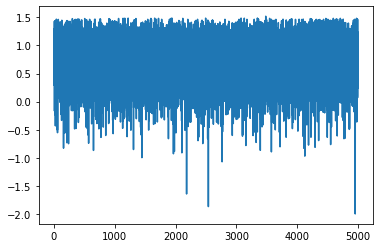

In [81]:
import matplotlib.pyplot as plt
plt.plot(pred["sex"])
